In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np
import pandas as pd
import optuna
from sklearn import datasets, metrics
from sklearn.model_selection import KFold, StratifiedKFold,GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from statistics import mean
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


/kaggle/input/icr-identify-age-related-conditions/sample_submission.csv
/kaggle/input/icr-identify-age-related-conditions/greeks.csv
/kaggle/input/icr-identify-age-related-conditions/train.csv
/kaggle/input/icr-identify-age-related-conditions/test.csv


In [2]:
train_df=pd.read_csv('/kaggle/input/icr-identify-age-related-conditions/train.csv')
test_df=pd.read_csv('/kaggle/input/icr-identify-age-related-conditions/test.csv')
greeks_df=pd.read_csv('/kaggle/input/icr-identify-age-related-conditions/greeks.csv')
test_Id=test_df["Id"]

In [3]:
from sklearn.model_selection import KFold,StratifiedKFold,train_test_split,GridSearchCV
from sklearn.metrics import roc_auc_score,accuracy_score,confusion_matrix,ConfusionMatrixDisplay,RocCurveDisplay

import time 
from xgboost import XGBClassifier
from sklearn.metrics import log_loss

In [4]:
train_df.head()

,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,...,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class
0,000ff2bfdfe9,0.209377,3109.03329,85.200147,22.394407,8.138688,0.699861,0.025578,9.812214,5.555634,...,7.298162,1.73855,0.094822,11.339138,72.611063,2003.810319,22.136229,69.834944,0.120343,1
1,007255e47698,0.145282,978.76416,85.200147,36.968889,8.138688,3.632190,0.025578,13.517790,1.229900,...,0.173229,0.49706,0.568932,9.292698,72.611063,27981.562750,29.135430,32.131996,21.978000,0
2,013f2bd269f5,0.470030,2635.10654,85.200147,32.360553,8.138688,6.732840,0.025578,12.824570,1.229900,...,7.709560,0.97556,1.198821,37.077772,88.609437,13676.957810,28.022851,35.192676,0.196941,0
3,043ac50845d5,0.252107,3819.65177,120.201618,77.112203,8.138688,3.685344,0.025578,11.053708,1.229900,...,6.122162,0.49706,0.284466,18.529584,82.416803,2094.262452,39.948656,90.493248,0.155829,0
4,044fb8a146ec,0.380297,3733.04844,85.200147,14.103738,8.138688,3.942255,0.054810,3.396778,102.151980,...,8.153058,48.50134,0.121914,16.408728,146.109943,8524.370502,45.381316,36.262628,0.096614,1


In [5]:
train_df.dtypes

Id        object
AB       float64
AF       float64
AH       float64
AM       float64
AR       float64
AX       float64
AY       float64
AZ       float64
BC       float64
BD       float64
BN       float64
BP       float64
BQ       float64
BR       float64
BZ       float64
CB       float64
CC       float64
CD       float64
CF       float64
CH       float64
CL       float64
CR       float64
CS       float64
CU       float64
CW       float64
DA       float64
DE       float64
DF       float64
DH       float64
DI       float64
DL       float64
DN       float64
DU       float64
DV       float64
DY       float64
EB       float64
EE       float64
EG       float64
EH       float64
EJ        object
EL       float64
EP       float64
EU       float64
FC       float64
FD       float64
FE       float64
FI       float64
FL       float64
FR       float64
FS       float64
GB       float64
GE       float64
GF       float64
GH       float64
GI       float64
GL       float64
Class      int64
dtype: object

In [6]:
test_df.dtypes

Id      object
AB     float64
AF     float64
AH     float64
AM     float64
AR     float64
AX     float64
AY     float64
AZ     float64
BC     float64
BD     float64
BN     float64
BP     float64
BQ     float64
BR     float64
BZ     float64
CB     float64
CC     float64
CD     float64
CF     float64
CH     float64
CL     float64
CR     float64
CS     float64
CU     float64
CW     float64
DA     float64
DE     float64
DF     float64
DH     float64
DI     float64
DL     float64
DN     float64
DU     float64
DV     float64
DY     float64
EB     float64
EE     float64
EG     float64
EH     float64
EJ      object
EL     float64
EP     float64
EU     float64
FC     float64
FD     float64
FE     float64
FI     float64
FL     float64
FR     float64
FS     float64
GB     float64
GE     float64
GF     float64
GH     float64
GI     float64
GL     float64
dtype: object

In [7]:
num_cols = train_df.select_dtypes(include=["float64"]).columns.tolist()
cat_cols = train_df.select_dtypes(include=["object"]).columns.tolist()
cat_cols.remove("Id")

In [8]:
total_row_train=train_df.shape
total_row_test=test_df.shape
type(total_row_train[0])

int

In [9]:
num=len(train_df[train_df["Class"]==1])
percentage=num/(total_row_train[0])*100
print(f"there are {num} Classes are '1', which is {percentage:.2f}% total training dataset.")

num=len(train_df[train_df["Class"]==0])
percentage=num/(total_row_train[0])*100
print(f"there are {num} Classes are '0', which is {percentage:.2f}% total training dataset.")


there are 108 Classes are '1', which is 17.50% total training dataset.
there are 509 Classes are '0', which is 82.50% total training dataset.


In [10]:
train_df.isnull().sum().loc[train_df.isnull().sum()>0]

BQ    60
CB     2
CC     3
DU     1
EL    60
FC     1
FL     1
FS     2
GL     1
dtype: int64

In [11]:
test_df.isnull().sum().loc[train_df.isnull().sum()>0]

BQ    0
CB    0
CC    0
DU    0
EL    0
FC    0
FL    0
FS    0
GL    0
dtype: int64

In [12]:
train_df.describe()

,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,...,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class
count,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,...,616.000000,617.000000,615.000000,617.000000,617.000000,617.000000,617.000000,617.000000,616.000000,617.000000
mean,0.477149,3502.013221,118.624513,38.968552,10.128242,5.545576,0.060320,10.566447,8.053012,5350.388655,...,5.433199,3.533905,0.421501,20.724856,131.714987,14679.595398,31.489716,50.584437,8.530961,0.175041
std,0.468388,2300.322717,127.838950,69.728226,10.518877,2.551696,0.416817,4.350645,65.166943,3021.326641,...,11.496257,50.181948,1.305365,9.991907,144.181524,19352.959387,9.864239,36.266251,10.327010,0.380310
min,0.081187,192.593280,85.200147,3.177522,8.138688,0.699861,0.025578,3.396778,1.229900,1693.624320,...,0.173229,0.497060,0.067730,4.102182,72.611063,13.038894,9.432735,0.897628,0.001129,0.000000
25%,0.252107,2197.345480,85.200147,12.270314,8.138688,4.128294,0.025578,8.129580,1.229900,4155.702870,...,0.173229,0.497060,0.067730,14.036718,72.611063,2798.992584,25.034888,23.011684,0.124392,0.000000
50%,0.354659,3120.318960,85.200147,20.533110,8.138688,5.031912,0.025578,10.461320,1.229900,4997.960730,...,3.028141,1.131000,0.250601,18.771436,72.611063,7838.273610,30.608946,41.007968,0.337827,0.000000
75%,0.559763,4361.637390,113.739540,39.139886,8.138688,6.431634,0.036845,12.969516,5.081244,6035.885700,...,6.238814,1.512060,0.535067,25.608406,127.591671,19035.709240,36.863947,67.931664,21.978000,0.000000
max,6.161666,28688.187660,1910.123198,630.518230,178.943634,38.270880,10.315851,38.971568,1463.693448,53060.599240,...,137.932739,1244.227020,31.365763,135.781294,1497.351958,143790.071200,81.210825,191.194764,21.978000,1.000000


In [13]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler,OneHotEncoder,StandardScaler
from sklearn.utils import class_weight
from sklearn.metrics import accuracy_score


imputer=SimpleImputer(strategy="mean")
numeric_df=pd.DataFrame(imputer.fit_transform(train_df[num_cols]),columns=num_cols
                )

scaler=MinMaxScaler()
scaled_numeric_df=pd.DataFrame(scaler.fit_transform(numeric_df),columns=num_cols)

encoder=OneHotEncoder(sparse_output=False,handle_unknown="ignore")
encoded_cat_df=pd.DataFrame(encoder.fit_transform(train_df[cat_cols]),columns=encoder.get_feature_names_out(cat_cols))


processed_df=pd.concat([scaled_numeric_df,encoded_cat_df],axis=1)

In [14]:
class Classifier:
    def __init__(self,params):
        self.params=params
        if params["standardize"]=="StandardScaler":
            self.standardizer=StandardScaler()
        elif params["standardize"]=="MinMaxScaler":
            self.standardizer=MinMaxScaler()
        elif params["standardize"]=="Noscaler" :
            self.standardizer=Noscaler()
        
        if params["classifier_name"]=="RandomForest":
            self.classifier=RandomForestClassifier(**params["classifier_params"])
        elif params["classifier_name"]=="XGB":
            self.classifier=XGBClassifier(**params["classifier_params"])
        
   
    def _fit_and_predict_core(self,x,y=None,fitting=False,proba=False):
        if fitting==True:
            self.standardizer.fit(x)
        self.standardizer.transform(x)
        
        if fitting==True:
            self.classifier.fit(x,y)
        
        if y is None:
            if proba:
                return self.classifier.predict_proba(x)
            else:
                return self.classifier.predict(x)
        return None
    
    def fit(self,x,y):
        self._fit_and_predict_core(x,y,fitting=True)
        return self
    
    def predict(self,x):
        pred_y=self._fit_and_predict_core(x)
        return pred_y
    
    def predict_proba(self,x):
        pred_y=self._fit_and_predict_core(x,proba=True)
        return pred_y

class Objective:
    def __init__(self,x,y,label_index):
        self.x=x
        self.y=y
        self.label_index=label_index
        self.best_score=0
        self.best_params=None
    
    def __call__(self,trial):
        x=self.x
        y=self.y
        params=self.generate_params(trial,x)
        
        classifier=Classifier(params)
        
        skf=StratifiedKFold(n_splits=5,random_state=2019,shuffle=True)
        
        acc=[]
        
        for train,test in skf.split(x,y):
            train_y=y.iloc[train].values
            test_y=y.iloc[test].values
            train_x=x.iloc[train].values
            test_x=x.iloc[test].values
            
            classifier.fit(train_x,train_y)
            pred_y=classifier.predict(test_x).reshape(-1).astype(np.int)
            
        
            acc.append(metrics.accuracy_score(test_y,pred_y))
        
        f1_score=mean(acc)
        if self.best_score<f1_score:
            self.best_score-f1_score
            self.best_params=params
        return f1_score
    def generate_params(self,trial,x):
        params={}
        
        params["standardize"]=trial.suggest_categorical("standardize",["StandardScaler","MinMaxScaler"])
        params["classifier_name"]=trial.suggest_categorical("classifier_name",["RandomForest","XGB"])
        classifier_params={}
        if params["classifier_name"]=="RandomForest":
            classifier_params['n_estimators'] = trial.suggest_categorical(
                'rf_n_estimators', [5, 10, 20, 30, 50, 100])
            classifier_params['max_features'] = trial.suggest_categorical(
                'rf_max_features', ["auto", 0.2, 0.4, 0.6, 0.8])
            
            classifier_params['n_jobs'] = -1
        elif params["classifier_name"]=="XGB":
            classifier_params["n_estimators"]=trial.suggest_categorical("rf_x_estimators",range(100,1000,90))
            classifier_params["max_depth"]=trial.suggest_categorical("rf_max_depth",[3,4,5,6,7])
            
        else:
            raise RuntimeError('unspport classifier', params['classifier_name'])
            
        params["classifier_params"]=classifier_params 
        return params

import optuna
label_index=train_df.index.tolist
objective = Objective(x=processed_df, y=train_df["Class"], label_index=label_index)
study = optuna.create_study(direction='maximize')
param2=study.optimize(objective, n_trials=30)

[I 2023-05-27 02:38:39,797] A new study created in memory with name: no-name-355b75f9-bfbf-4546-aab7-f6deb47eb0bc
/tmp/ipykernel_20/4205274349.py:70: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_y=classifier.predict(test_x).reshape(-1).astype(np.int)
/tmp/ipykernel_20/4205274349.py:70: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify 

In [15]:
FOLDS=20
SEED=1004
SUM=[]
X=processed_df
y=train_df["Class"]
xgb_models = []
xgb_oof = []
f_imp = []
weights=class_weight.compute_sample_weight("balanced",y)
skf=StratifiedKFold(n_splits=FOLDS,shuffle=True,random_state=SEED)
for fold,(train_idx,val_idx) in enumerate(skf.split(X,y)):
    X_train,y_train=X.iloc[train_idx],y.iloc[train_idx]
    X_valid,y_valid=X.iloc[val_idx],y.iloc[val_idx]
    watchlist=[(X_train,y_train),(X_valid,y_valid)]
    
    model=XGBClassifier(n_estimators=180,max_depth=6,)
    model.fit(X_train,y_train,sample_weight=weights[train_idx],eval_set=watchlist,early_stopping_rounds=300,verbose=0)
    pred=model.predict_proba(X_valid)[:,1]
    val_score=log_loss(y_valid,pred,sample_weight=weights[val_idx])
    best_iter=model.best_iteration
    idx_pred_target=np.vstack([val_idx,pred,y_valid])
    f_imp.append({i: j for i, j in zip(X.columns, model.feature_importances_)})
    SUM.append(val_score)
    xgb_oof.append(idx_pred_target)
    xgb_models.append(model)
    print(val_score,best_iter)

print(mean(SUM))
model.feature_importances_ 

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


0.2508456604717765 116


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


0.1479213067852446 172


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


0.0712753916035471 179


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


0.1461436287803914 63


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


0.18362006928340469 30


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


0.23839939077741287 26


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


0.5690950597191956 22


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


0.10830171204815468 24


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


0.5912489053668807 6


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


0.19320494869493376 44


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


0.07784711571952048 78


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


0.7082456198515669 6


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


0.12515445715837611 118


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


0.262819872636813 11


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


0.39381752610383536 31


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


0.3026994275368179 26


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


0.34560193314781995 167


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


0.1686727663990784 153


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


0.21094667913260548 47


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


0.428516254095151 19
0.2762188862656263


array([0.12488682, 0.0112883 , 0.00983688, 0.00766707, 0.01636977,
       0.00502312, 0.01758645, 0.        , 0.02388853, 0.00697941,
       0.00592348, 0.00881673, 0.02831866, 0.06917676, 0.        ,
       0.00433083, 0.0140763 , 0.01205559, 0.00778061, 0.00311835,
       0.00033796, 0.05603885, 0.0281275 , 0.01473269, 0.00181138,
       0.02405679, 0.01820397, 0.00480473, 0.0136986 , 0.00542612,
       0.0253596 , 0.00810421, 0.09454749, 0.        , 0.01312267,
       0.01017638, 0.03818991, 0.01984661, 0.01351308, 0.01077646,
       0.01094287, 0.01231806, 0.00484048, 0.06130891, 0.01202841,
       0.01814028, 0.01051389, 0.00902247, 0.00033033, 0.00337759,
       0.00994738, 0.05121296, 0.00511133, 0.00227907, 0.01062729,
       0.        , 0.        ], dtype=float32)

In [16]:
model2=RandomForestClassifier(n_estimators=100,random_state=0,max_features=0.2)
skf=StratifiedKFold(n_splits=5,random_state=2019,shuffle=True)
for train,test in skf.split(processed_df,train_df["Class"]):
            train_y=train_df["Class"].iloc[train].values
            test_y=train_df["Class"].iloc[test].values
            train_x=processed_df.iloc[train].values
            test_x=processed_df.iloc[test].values
            
            model2.fit(train_x,train_y)

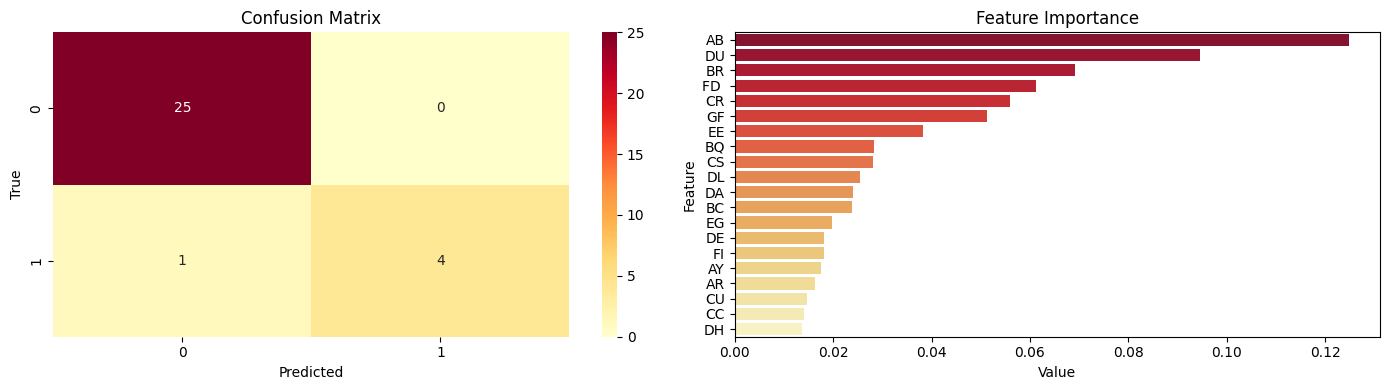

In [17]:
cm = confusion_matrix(y_valid, model.predict(X_valid))

# Feature Importance for the last model
feature_imp = pd.DataFrame({'Value':xgb_models[-1].feature_importances_, 'Feature':X.columns})
feature_imp = feature_imp.sort_values(by="Value", ascending=False)
feature_imp_top20 = feature_imp.iloc[:20]

fig, ax = plt.subplots(1, 2, figsize=(14, 4))

# Subplot 1: Confusion Matrix
sns.heatmap(cm, annot=True, fmt='d', ax=ax[0], cmap='YlOrRd')
ax[0].set_title('Confusion Matrix')
ax[0].set_xlabel('Predicted')
ax[0].set_ylabel('True')

# Subplot 2: Feature Importance
sns.barplot(x="Value", y="Feature", data=feature_imp_top20, ax=ax[1], palette='YlOrRd_r')
ax[1].set_title('Feature Importance')

plt.tight_layout()
plt.show()

In [18]:
test_df=test_df.drop(["Id"],axis=1)

In [19]:
num_cols = test_df.select_dtypes(include=["float64"]).columns.tolist()
cat_cols = test_df.select_dtypes(include=["object"]).columns.tolist()

In [20]:
test_df["EJ_A"]=0
test_df["EJ_B"]=0
test_df["EJ_A"][test_df["EJ"]=="A"]=1
test_df["EJ_B"][test_df["EJ"]=="B"]=1
test_df=test_df.drop(columns=["EJ"],axis=1)

/tmp/ipykernel_20/2542570503.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df["EJ_A"][test_df["EJ"]=="A"]=1
/tmp/ipykernel_20/2542570503.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df["EJ_B"][test_df["EJ"]=="B"]=1


In [21]:
pred_df=pd.DataFrame(model.predict_proba(test_df),columns=["class_0","class_1"])
pred2_df=pd.DataFrame(model2.predict_proba(test_df),columns=["class_0","class_1"])

/opt/conda/lib/python3.10/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


In [22]:
pred_concat_df=pred_df/2+pred2_df/2
pred_concat_df

,class_0,class_1
0,0.665937,0.334063
1,0.665937,0.334063
2,0.665937,0.334063
3,0.665937,0.334063
4,0.665937,0.334063


In [23]:
submission_df = pd.concat([test_Id,pred_concat_df],axis=1)
submission_df.to_csv('submission.csv', index=False)

In [24]:
submission_df

,Id,class_0,class_1
0,00eed32682bb,0.665937,0.334063
1,010ebe33f668,0.665937,0.334063
2,02fa521e1838,0.665937,0.334063
3,040e15f562a2,0.665937,0.334063
4,046e85c7cc7f,0.665937,0.334063
